# GTZAN - Deep Learning

`Music Genre Classification Problem`. Experts have been trying for a long time to understand sound & what differentiates one from another. How to visualize sound. What makes one tone different from another.

We are going to analyze the features extracted from the GTZAN dataset and build different type of ensemble models to see how better we can differentiate one genre from another.

Our Datasets contains 10 genres:-
- Blues
- Classical
- Country
- Disco
- Hiphop
- Jazz
- Metal
- Pop
- Reggae
- Rock


# Reading & Understanding Data
## Importing Libraries

In [47]:
TF_ENABLE_ONEDNN_OPTS=0
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import os
import librosa.display as lplt


# Data preprocessing
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from visualkeras import layered_view

# Tensor and Keras
import tensorflow_hub as hub
from tensorflow import keras
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping


seed = 12
np.random.seed(seed)

### Loading Dataset

In [63]:
pwd= os.getcwd()
df = pd.read_csv(pwd+'/data/audio_conversions/flac/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,hiphop.00098.0.flac,220500.0,0.596983,0.061825,0.113581,0.002475,2602.364701,2.858259e+05,2358.812648,34125.708008,...,13.002827,-2.532734,7.511455,-5.120455,5.146627,-1.233386,1.603065,-5.701591,-1.343788,hiphop
1,hiphop.00098.1.flac,220500.0,0.530756,0.075125,0.119397,0.002136,2595.429909,3.010835e+05,2352.305544,53371.596707,...,15.618703,-3.453837,9.259300,-4.637610,5.337623,-2.814586,2.468744,-4.281312,0.411404,hiphop
2,hiphop.00098.2.flac,220500.0,0.477404,0.084681,0.123631,0.001833,2418.936849,3.083607e+05,2313.897570,58223.917386,...,15.665563,-3.034774,10.626509,-4.615786,5.857599,-3.372447,0.955466,-8.141206,-1.436828,hiphop
3,hiphop.00027.0.flac,220500.0,0.458244,0.093813,0.132664,0.001860,2886.257744,1.454920e+06,2729.835051,234392.929477,...,2.769350,2.395925,2.513880,-5.335607,5.089479,-6.007478,3.040442,-2.087979,-6.833474,hiphop
4,hiphop.00027.1.flac,220500.0,0.405876,0.098081,0.135248,0.001815,2571.057582,9.546244e+05,2603.564982,197898.878332,...,1.400797,2.113721,4.235840,-5.292143,6.494158,-5.967233,1.898025,-3.200086,-6.437558,hiphop


### About the dataset

In [50]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (2997, 60)
Count of Positive and Negative samples


,index,label
0,hiphop,300
1,blues,300
2,metal,300
3,country,300
4,reggae,300
5,pop,300
6,rock,300
7,classical,300
8,disco,300
9,jazz,297


# Data Visualization

In [51]:
audio_fp = pwd + '/data/audio_conversions/flac/genres_original/blues/blues.00000.flac'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [52]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

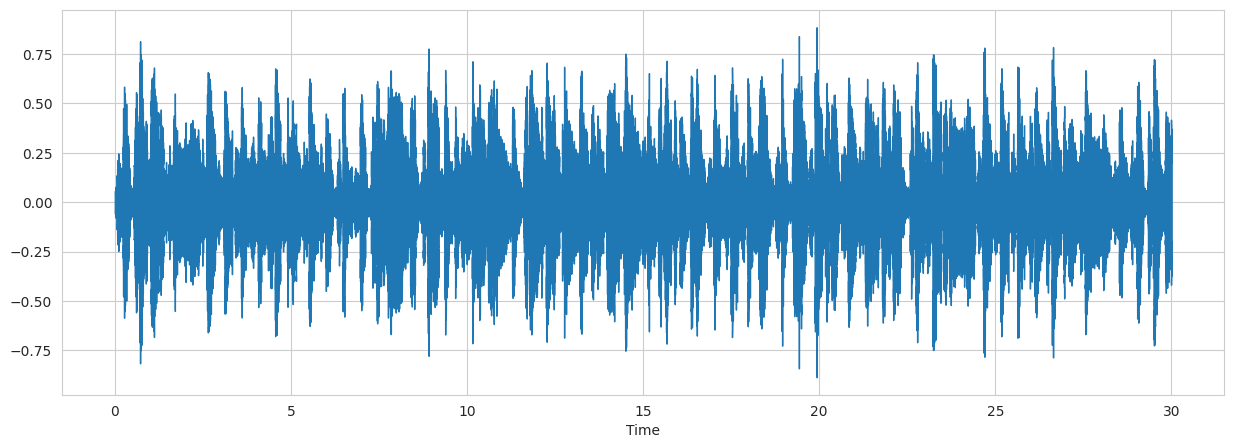

In [53]:
# plot sample file
plt.figure(figsize=(15,5))
lplt.waveshow(audio_data)
plt.show()

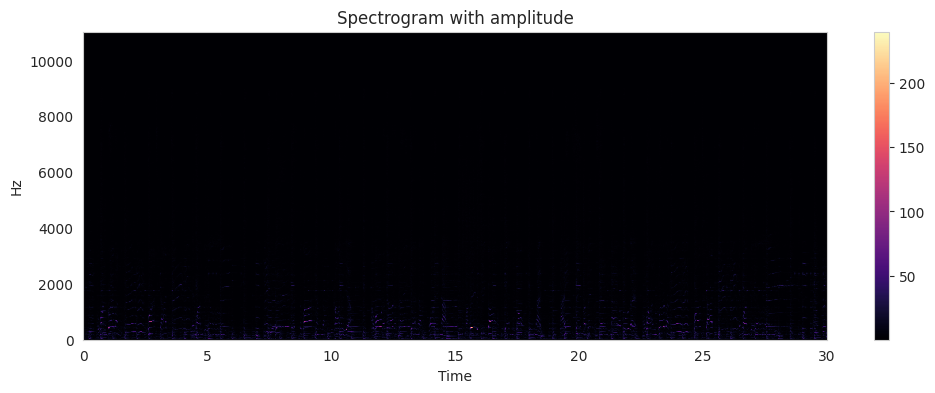

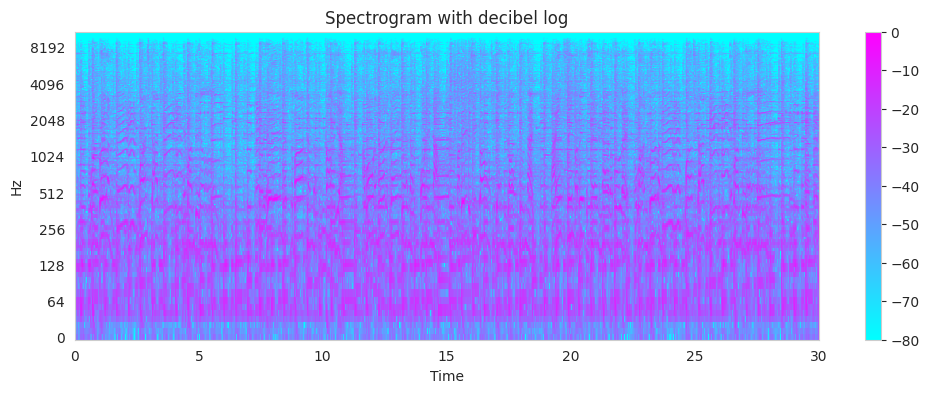

In [54]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

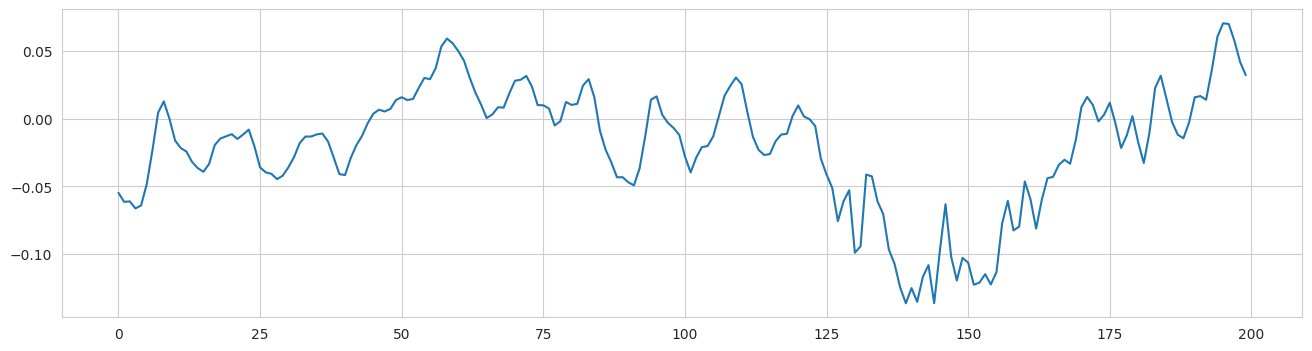

In [55]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

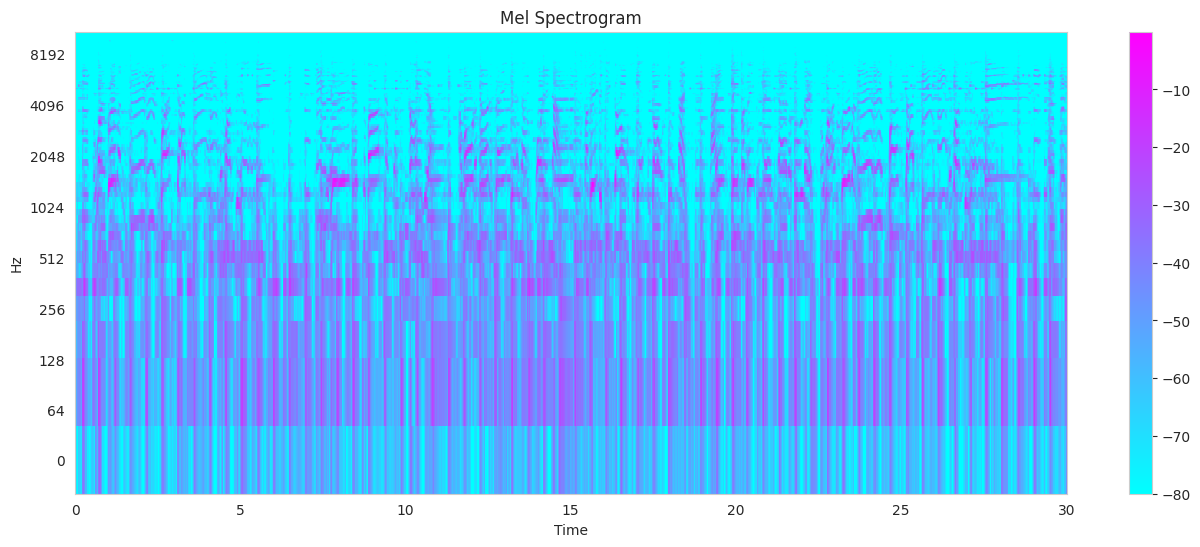

In [56]:
mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

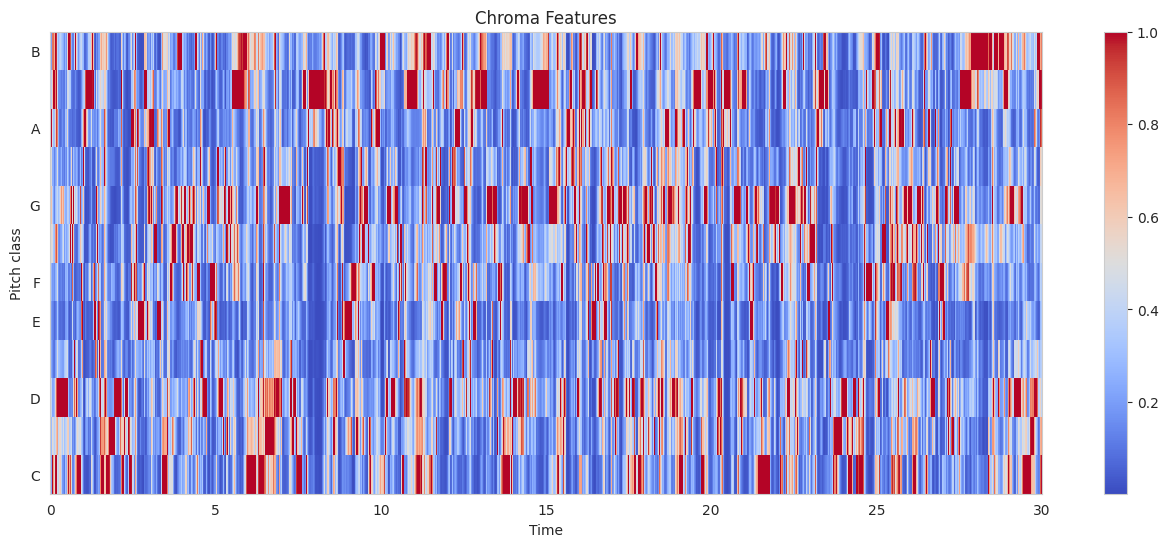

In [57]:
chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

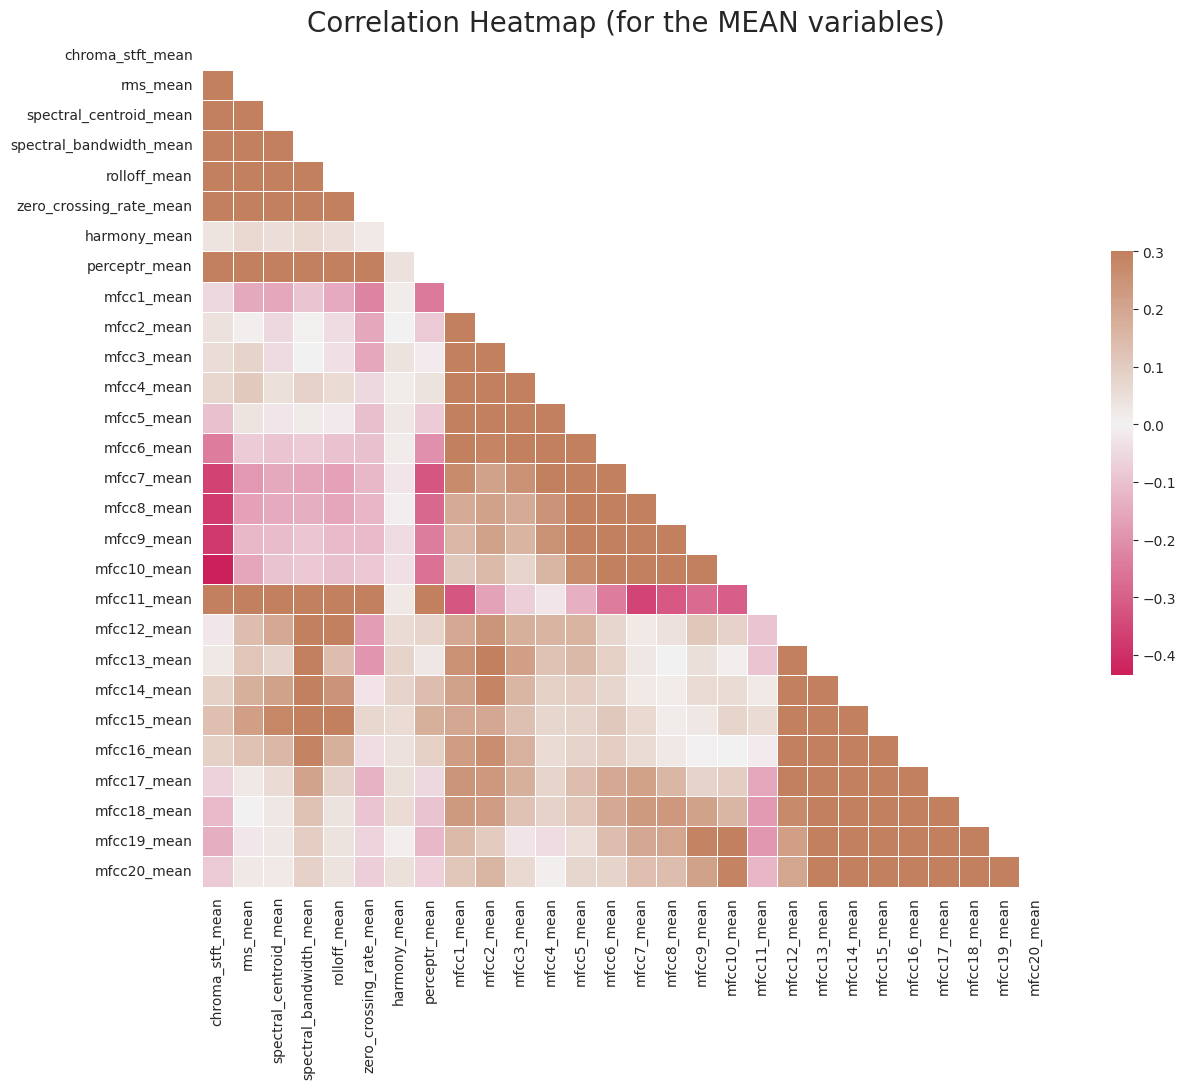

In [58]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr_Heatmap.png")

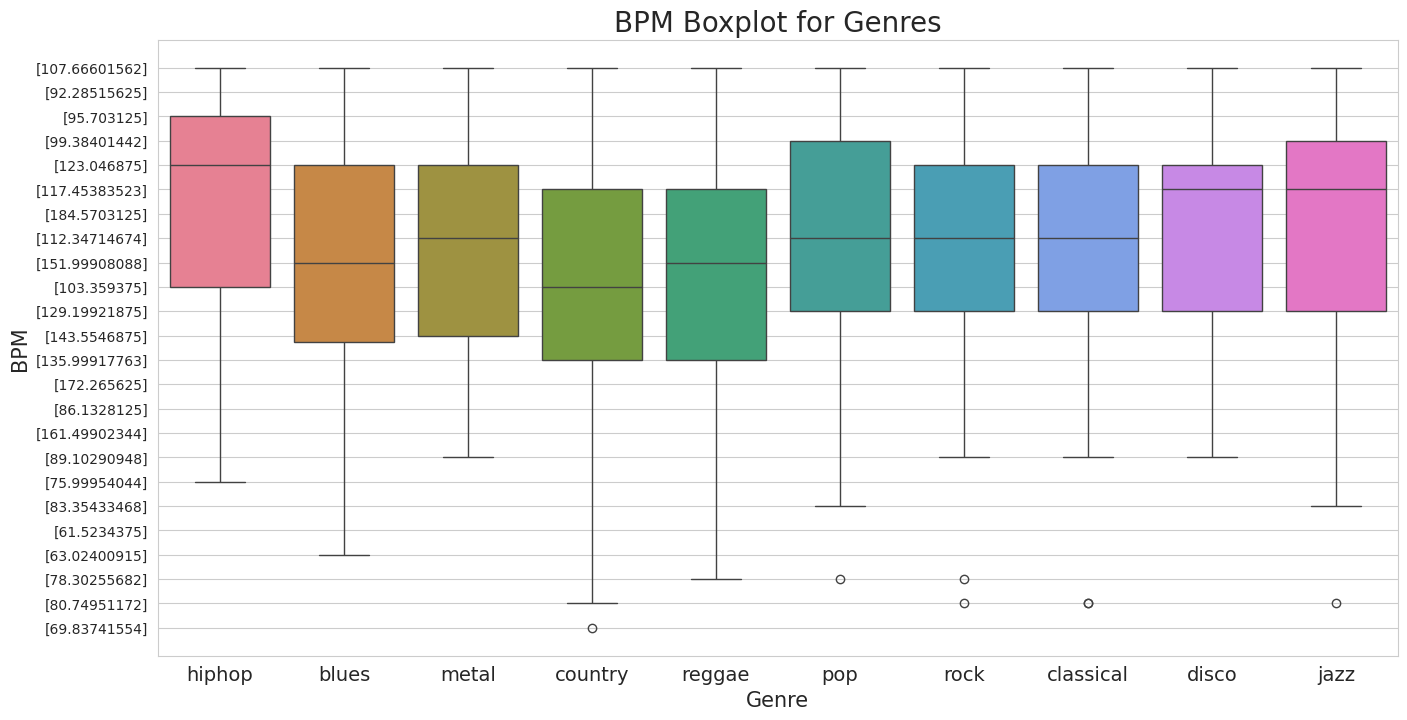

In [59]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

In [61]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

ValueError: could not convert string to float: '[107.66601562]'

# Data Preparation

- Treat missing values.
- Outlier Treatment
- Define dummy variables for categorical variables.

## Missing Value Treatment

In [ ]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

`No null values in the dataset`



`There are no categorical variable as such. Hence, Dummy variable creation is not needed.`

## Encode Genre Label

In [ ]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

In [ ]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

# Split Train, Dev & Test Sets

In [ ]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [ ]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [ ]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

In [ ]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

## Scale the Features

In [ ]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Model Building

In [ ]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
import os
from visualkeras import layered_view
TF_ENABLE_ONEDNN_OPTS=0
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.random.set_seed(seed)

In [ ]:
ACCURACY_THRESHOLD = 0.90

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer, loss='sparse_categorical_crossentropy'):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])
# Importing necessary libraries

# Data preprocessing
import pandas as pd
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from visualkeras import layered_view

# Model
import tensorflow_hub as hub
from tensorflow import keras
from keras_preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences # Python 3.9+
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')
def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()


In [ ]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=70, optimizer='adam')

In [ ]:
plotHistory(model_1_history)

In [ ]:
layered_view(model_1, legend = True)

In [ ]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=100, optimizer='adam')

In [ ]:
plotHistory(model_2_history)

In [ ]:
layered_view(model_2, legend = True)

In [ ]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=700, optimizer='sgd')

In [ ]:
plotHistory(model_3_history)

In [ ]:
layered_view(model_3, legend = True)

In [ ]:
model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(10, activation='softmax'),
])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=500, optimizer='rmsprop')

In [ ]:
plotHistory(model_4_history)

In [ ]:
layered_view(model_4, legend = True)

# Various Sklearn Models
## Models 5 - 9

In [ ]:
    
# create an instance of each classification algorithm
g=GaussianNB()
b=BernoulliNB()
KN=KNeighborsClassifier()
D=DecisionTreeClassifier()
XGB=XGBClassifier()

algos=[g,b,KN,D,XGB]
algo_names=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'GaussianNB','BernoulliNB','KNeighborsClassifier','DecisionTreeClassifier','XGBClassifier']
   
accuracy_scored=[]
    



# Model Evaluation

In [ ]:
test_loss_arr = []
accuracy_scored = []

test_loss, test_acc  = model_1.evaluate(X_test, y_test, batch_size=128)
test_loss_arr.append(test_loss)
accuracy_scored.append(test_acc)

test_loss, test_acc  = model_2.evaluate(X_test, y_test, batch_size=128)
test_loss_arr.append(test_loss)
accuracy_scored.append(test_acc)

test_loss, test_acc  = model_3.evaluate(X_test, y_test, batch_size=128)
test_loss_arr.append(test_loss)
accuracy_scored.append(test_acc)

test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
test_loss_arr.append(test_loss)
accuracy_scored.append(test_acc)



for index, test_l in enumerate(test_loss_arr):
    print(f'The test loss for model {index+1} :',test_l)

# fit and predict for each Algo
for item in algos:
    item.fit(X_train,y_train)
    item.predict(X_test)
    accuracy_scored.append(accuracy_score(y_test,item.predict(X_test)))

# show results in a DataFrame
#accuracy_score = test_acc_arr.extend(accuracy_scored)
result = pd.DataFrame(accuracy_scored, columns=["Accuracy"])
result['Algos']=algo_names
result = result.sort_values(by=['Accuracy'])

print(result)
colors = ['skyblue', 'lightgreen'] * (len(result) // 2 + 1)

# Plotting
plt.figure(figsize=(20, 6))
plt.bar(result['Algos'], result['Accuracy'], color=colors[:len(result)])
plt.xlabel('Accuracy', fontweight='bold', fontsize=12)
plt.title('Accuracy of Various Algorithms FLAC (3 seconds)', fontsize=16)
print("\n\n")
plt.gca() # Invert y-axis to have the highest accuracy at the top
plt.show()
